In [2]:
# Import libraries
# import demes
# import demesdraw
import msprime
import tskit
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
# Get parameters
N=10000
time_merge=25000
# Note: Migration is important in order for the lineages to coalesce, very small migration makes the algorithm take much more time!
migration_rate=25e-8 # N*m / close to 1 is close to critical limit
assert N*migration_rate < 1 , "N*migration rate > 1, change to a lower migration rate."
proportions=[ 1 / 3, 1 / 3 , 1 / 3]

seqlen=1e8 / 100
mrate=1.5e-8 / 100
recomrate=1e-9 / 100

sampling_times = [time_merge-1,time_merge-50,time_merge-100,time_merge-1000,time_merge-5000,time_merge-10000,time_merge-20000,0]
nsample=100

In [4]:
# Simulate demography of 3 ancestral pops merging into one.
demography = msprime.Demography()
demography.add_population(name="A",initial_size=N,initially_active=False,default_sampling_time=time_merge+1)
demography.add_population(name="B",initial_size=N,initially_active=False,default_sampling_time=time_merge+1)
demography.add_population(name="C",initial_size=N,initially_active=False,default_sampling_time=time_merge+1)
demography.add_population(name="merged",initial_size=3*N)
demography.add_admixture(time=time_merge,derived="merged", ancestral=["A","B","C"],proportions=proportions)
demography.add_symmetric_migration_rate_change(time=time_merge, populations=["A", "B","C"], rate=migration_rate)
demography.debug()

In [5]:
# # Visualize demography with DEMES
# graph = msprime.Demography.to_demes(demography)
# fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
# demesdraw.tubes(graph, ax=ax, seed=1)
# plt.show()

In [14]:
l = [[1,3,4,5,6],[1,3,4,5,6]]
np.mean(l,axis=0)

array([1., 3., 4., 5., 6.])

In [6]:
# Sampling by simulating ancestry

# Sampling of merged population at different time points and simulate mutations

def sample_time(pop="merged",nsample=100,time=0,recomrate=1e-9,mrate=1e-08):
    ts = msprime.sim_ancestry(samples=[msprime.SampleSet(nsample,population=pop, time=time)],sequence_length=seqlen, demography=demography, recombination_rate=recomrate)
    ts = msprime.sim_mutations(ts, rate=mrate)
    afs = ts.allele_frequency_spectrum(mode="site", polarised=False, span_normalise=False)
    return ts,afs

nruns = 100

treeseq_list_before = []
asf_list_before = []

for pop in ["A","B","C"]:
    ts,afs = sample_time(pop=pop,time=time_merge+1,mrate=mrate,recomrate=recomrate)
    treeseq_list_before.append(ts)
    asf_list_before.append(afs)

# for pop in ["A","B","C"]:
#     for run in range(nruns):
#         temp_asf = []
#         temp_tsq = []
#         ts,afs = sample_time(pop=pop,time=time_merge+1,mrate=mrate,recomrate=recomrate)
#         temp_asf.append(afs)
#         temp_tsq.append(ts)
#     afs = np.mean(temp_asf,axis=0)
#     ts = random.choice(temp_tsq)
#     treeseq_list_before.append(ts)
#     asf_list_before.append(afs)

# treeseq_list = []
# asf_list = []

# for time in sampling_times:
#     ts,afs = sample_time(time=time,mrate=mrate,recomrate=recomrate)
#     treeseq_list.append(ts)
#     asf_list.append(afs)


KeyboardInterrupt: 

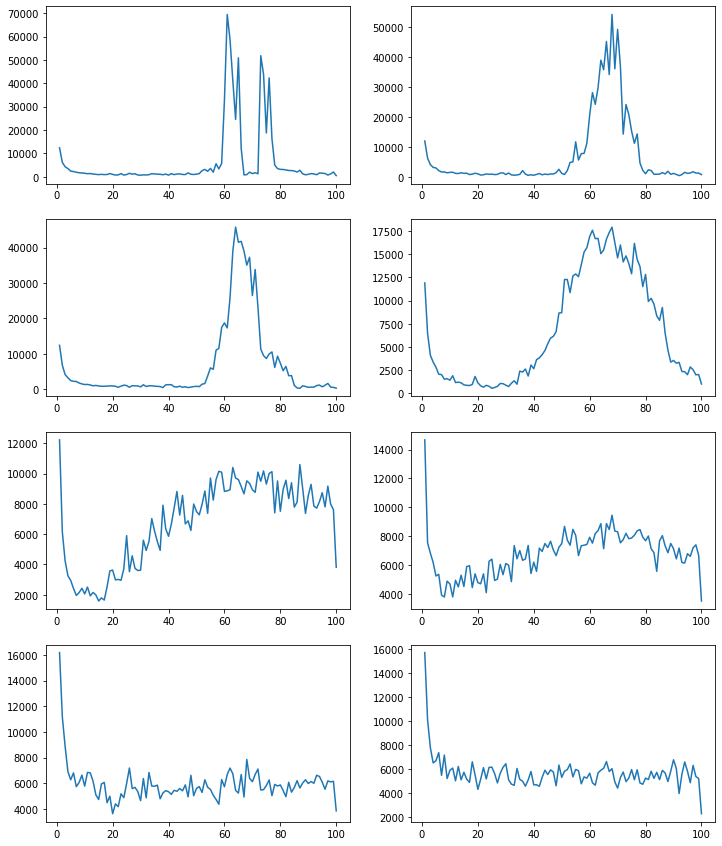

In [ ]:
n = round(len(asf_list)/2)
fig, axs = plt.subplots(n, 2,figsize=(12,15))

for i,axis in enumerate(fig.axes):
    axis.plot(np.arange(1,nsample+1),asf_list[i][1:nsample+1])

plt.savefig('Figures/SFS_merged.png')

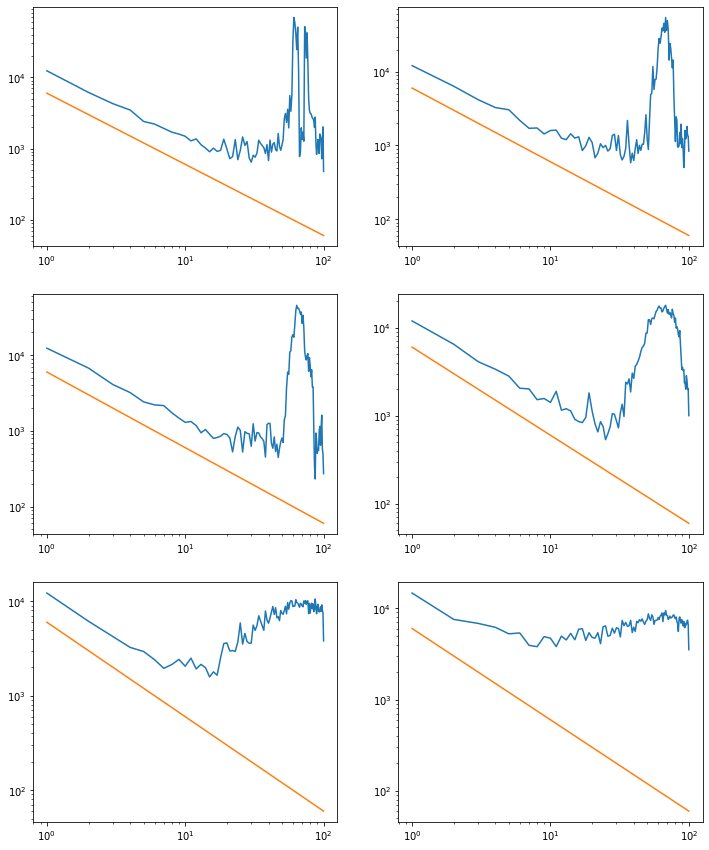

In [41]:
u = mrate*seqlen # L \mu, the number of mutations per genration across all sites
fig, axs = plt.subplots(n, 2,figsize=(12,15))
for i,axis in enumerate(fig.axes):
    axis.loglog(np.arange(1,nsample+1),asf_list[i][1:nsample+1])
    axis.loglog(np.arange(1,nsample+1),(2*3*N*u)/np.arange(1,nsample+1))

plt.savefig('Figures/SFS_merged_loglog.png')

IndexError: invalid index to scalar variable.

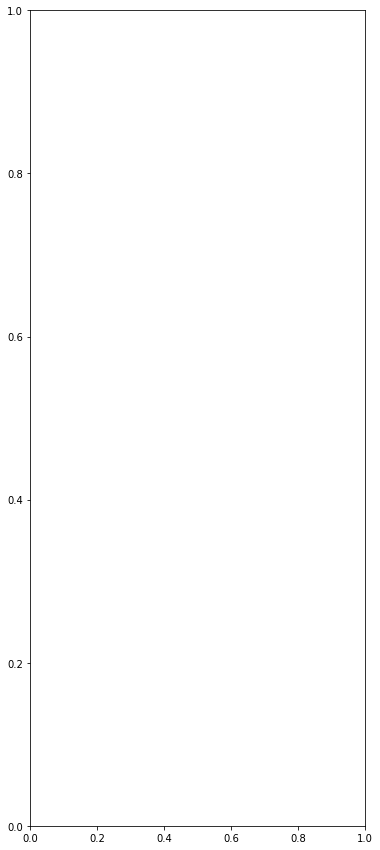

In [7]:
n = len(asf_list_before)
fig, axs = plt.subplots(n, 1, figsize=(6,15))

for i,axis in enumerate(fig.axes):
    axis.plot(asf_list_before[i][1:nsample+1])
plt.show()


IndexError: invalid index to scalar variable.

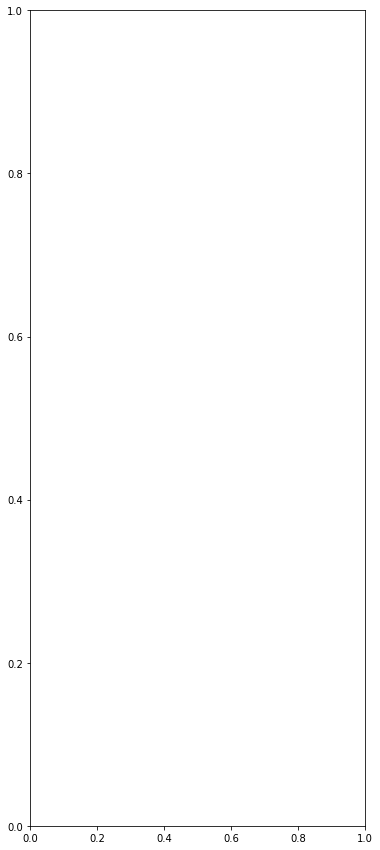

In [8]:
fig, axs = plt.subplots(n, 1, figsize=(6,15))
for i,axis in enumerate(fig.axes):
    axis.loglog(np.arange(1,nsample+1),asf_list_before[i][1:nsample+1])
    axis.loglog(np.arange(1,nsample+1),(2*N*u)/np.arange(1,nsample+1))

plt.show()

In [29]:
treeseq_list

In [38]:
["t" + str(timepoint) for timepoint in np.arange(1,len(treeseq_list))] + ["tpresent"]

['tpresent', 't1', 't2', 't3', 't4', 't5', 't6', 't7']

In [40]:
for t,ts in dict(zip(["t" + str(timepoint) for timepoint in np.arange(1,len(treeseq_list))] + ["tpresent"],treeseq_list)).items():
    with open(str("VCF_files/ts_")+str(t)+str(".vcf"), "w") as vcf_file:
        ts.write_vcf(vcf_file)

for t,ts in dict(zip(["A","B","C"],treeseq_list_before)).items():
    with open(str("VCF_files/ts_")+str(t)+str(".vcf"), "w") as vcf_file:
        ts.write_vcf(vcf_file)

In [ ]:
print("Sampling at time 0")
ts_t0 = msprime.sim_ancestry(samples=[msprime.SampleSet(100,"A", time=time_merge+1)], sequence_length=seqlen, demography=demography, recombination_rate=recomrate, random_seed=12)
ts_t0 = msprime.sim_mutations(ts_t0, rate=mrate, random_seed=5678)
print("writting VCF")
with open("vcf_files/ts_t0_m.vcf", "w") as vcf_file:
    ts_t0.write_vcf(vcf_file)
    
print("Sampling at time 1")
ts_t1 = msprime.sim_ancestry(samples=[msprime.SampleSet(100,population="merged", time=time_merge-1)],sequence_length=seqlen, demography=demography, recombination_rate=recomrate, random_seed=12)
ts_t1 = msprime.sim_mutations(ts_t1, rate=mrate, random_seed=5678)
print("writting VCF")
with open("vcf_files/ts_t1_m.vcf", "w") as vcf_file:
    ts_t1.write_vcf(vcf_file)

print("Sampling at time 2")
ts_t2 = msprime.sim_ancestry(samples=[msprime.SampleSet(100,population="merged", time=time_merge-50)],sequence_length=seqlen, demography=demography, recombination_rate=recomrate, random_seed=12)
ts_t2 = msprime.sim_mutations(ts_t2, rate=mrate, random_seed=5678)
print("writting VCF")
with open("vcf_files/ts_t2_m.vcf", "w") as vcf_file:
    ts_t2.write_vcf(vcf_file)

print("Sampling at time 3")
ts_t3 = msprime.sim_ancestry(samples=[msprime.SampleSet(100,population="merged", time=time_merge-100)],sequence_length=seqlen, demography=demography, recombination_rate=recomrate, random_seed=12)
ts_t3 = msprime.sim_mutations(ts_t3, rate=mrate, random_seed=5678)
print("writting VCF")
with open("vcf_files/ts_t3_m.vcf", "w") as vcf_file:
    ts_t3.write_vcf(vcf_file)

print("Sampling at time present")
ts_tpresent = msprime.sim_ancestry(samples=[msprime.SampleSet(100,population="merged", time=0)],sequence_length=seqlen, demography=demography, recombination_rate=recomrate, random_seed=12)
ts_tpresent = msprime.sim_mutations(ts_t1, rate=mrate, random_seed=5678)
print("writting VCF")
with open("vcf_files/ts_tpresent_m.vcf", "w") as vcf_file:
    ts_tpresent.write_vcf(vcf_file)

In [5]:
for indv in ts_t1.populations():
    print(indv.metadata)

{'description': '', 'name': 'A'}
{'description': '', 'name': 'B'}
{'description': '', 'name': 'C'}
{'description': '', 'name': 'merged'}
